In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import display
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline


%matplotlib inline

# 1. Load datasets

In [69]:
df = pd.read_csv('sample_shift.csv')

In [4]:
df.head()

,seller_id,year,make,model,trim,body_type,engine_type,mileage,accidents,owners,region,appraisal_date,acquistion_price,listing_date,list_price,sell_date,final_sale_price
0,P10XYZ,2017,Mazda,Mazda6,Grand Touring,sedan,internal-combustion,8500,0.000,1.000,San Francisco,2021-01-01,19000.000,2021-01-03,20300,2021-01-09,18950.000
1,P11XYZ,2015,Chevrolet,Impala,2LT,sedan,internal-combustion,50500,0.000,1.000,Dallas,2021-01-03,13300.000,2021-01-03,17400,2021-03-25,13200.000
2,P12XYZ,2012,Hyundai,Elantra,Limited,sedan,internal-combustion,109378,0.000,4.000,Los Angeles,2021-01-02,3200.000,2021-01-03,3841,2021-01-17,3800.000
3,P13XYZ,2011,Jeep,Grand Cherokee,Laredo,suv,internal-combustion,74600,0.000,1.000,Los Angeles,2021-01-02,10900.000,2021-01-03,14400,2021-01-07,11470.000
4,P14XYZ,2014,Honda,CR-V,LX,suv,internal-combustion,58358,0.000,1.000,San Francisco,2021-01-02,12600.000,2021-01-03,14400,2021-02-01,13450.000


In [5]:
df.columns

Index(['seller_id', 'year', 'make', 'model', 'trim', 'body_type',
       'engine_type', 'mileage', 'accidents', 'owners', 'region',
       'appraisal_date', 'acquistion_price', 'listing_date', 'list_price',
       'sell_date', 'final_sale_price'],
      dtype='object')

### **2. Preprocessing**

#### 2.1 Delete unwanted columns 

For initial analysis, I am deleteing listing date, list price and sell date as our primary focus is on acquisition price

In [70]:
# delete listing date,list price, sell date 
del_cols = ['listing_date','list_price', 'sell_date','seller_id']
df.drop(del_cols,axis=1,inplace=True)


#### 2.2 Remove duplicate rows

There are many duplicates in the data. There are 640k rows for 12k cars. For each car, listing price is changed at multiple instances of time and all the listing price changes are provided in the data. However as our primary focus is acquisition price, I am ignoring listing price. So I am modeling on 12k unique cars.

In [71]:
# drop duplicates
df = df.drop_duplicates(keep='first')
df = df.reset_index(drop=True)

#### 2.3 Process categorical variables

In [72]:
# get car based features 
df['make_model_trim'] = df['make']+' ' + df['model']+ ' ' +df['trim']
df['make_model'] =  df['make']+' ' + df['model']

#treat categorical variables
categorical_variables = ['make', 'model', 'trim', 'body_type',
       'engine_type','region', 'make_model_trim', 'make_model']

for col in categorical_variables:
  df[col] = df[col].str.lower() # covert to lower case
  df[col] = df[col].str.strip() # strip spaces



In [73]:
# Delete cars whose presence is less than 5 times. 
#This is typically cold start problem and should be handled seperately

df_cars =  pd.DataFrame(df['make_model'].value_counts()) # value counts
df_cars = df_cars.reset_index()
df_cars.columns = ['make_model','freq']

# get all cars which have atleast 5 rows of data present
cars_with_min_freq_5 =  df_cars[df_cars.freq > 5]['make_model'].to_list() 

#filter car based on the frequency
df = df[df.make_model.isin(cars_with_min_freq_5)]
df = df.reset_index(drop=True)

#### 2.4 Handle missing values

In [74]:
missing_values_count = df.isna().sum().sort_values(ascending=False).to_frame()
missing_values_count = missing_values_count.reset_index()
missing_values_count.columns = ['feature','number of missing values']
missing_values_count['Percentage of missing values(%)'] = (missing_values_count['number of missing values']/len(df))*100

missing_values_count = missing_values_count[missing_values_count['number of missing values']>0]
missing_values_count

,feature,number of missing values,Percentage of missing values(%)
0,accidents,1222,10.665
1,owners,922,8.047
2,region,8,0.070
3,final_sale_price,4,0.035


Replace missing values of accidents with 0. 
Assumption: when accidents are missing, I assume there are no accidents

In [75]:
df['accidents'] = df['accidents'].fillna(0)

Replace missing values of owners with 1. 
Assumption: when owners are missing, I assume there is only 1 owner

In [76]:
df['owners'] = df['owners'].fillna(1)

Replace missing values of region with most common region

In [77]:
most_common_region =  df['region'].value_counts().index[0]
df['region'] = df['region'].fillna(most_common_region)

Delete rows where final sale price is null as the number is very tiny

In [78]:
df = df[~df.final_sale_price.isna()]
df = df.reset_index(drop=True)

### 2.5 extract cars age at the time of appraisal

In [79]:
df['appraisal_year'] = df['appraisal_date'].apply(lambda x: int(x.split('-')[0]))

df['car_age'] = df['appraisal_year']  - df['year']
del df['appraisal_year']
del df['appraisal_date']

In [80]:
df['car_age'].head()

0     4
1     6
2     9
3    10
4     7
Name: car_age, dtype: int64

### **3. Create train and test files**


In [81]:
y = df.pop('acquistion_price')
X = df

In [82]:
# train test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2, 
                                                random_state=9)
print('number of training samples:', len(X_train))
print('number of test samples:', len(X_test))

number of training samples: 9163
number of test samples: 2291


### **4. Get average acquisiton price of each car in training data**

In [83]:
# Extract average sale prices based on make, model and trim from training data
make_model_trim_avg_final_price_dict =  X_train.groupby('make_model_trim')['final_sale_price'].mean().to_dict()
make_model_avg_final_price_dict =  X_train.groupby('make_model')['final_sale_price'].mean().to_dict()
make_avg_final_price_dict =  X_train.groupby('make')['final_sale_price'].mean().to_dict()

In [84]:
# Function to impute average sale price of the car.
'''Logic:
If make+model+trim details are available, impute with the avg value of make+model+trim 
If trim details are not available but only make+model details are available, impute with the avg value of make+model
If trim and model details are not available but only make details are available, impute with the avg value of make
If no details of the car are available, impute with average final sale price. -> cold start problem and can be 
handled better
'''

def impute_avg_final_price(x):
  if x['make_model_trim'] in make_model_trim_avg_final_price_dict:
    return make_model_trim_avg_final_price_dict[x['make_model_trim']]
  elif x['make_model'] in make_model_avg_final_price_dict:
    return make_model_avg_final_price_dict[x['make_model']]
  elif x['make'] in make_avg_final_price_dict:
    return make_avg_final_price_dict[x['make']]
  else:
    return X_train['final_sale_price'].mean()


In [85]:
#Impute prior average car sale price based on training data.
X_train['prior_avg_sale_price'] =  X_train.apply(impute_avg_final_price, axis=1)
X_test['prior_avg_sale_price'] =  X_test.apply(impute_avg_final_price, axis=1)

### **5. Label encoding for categorical variables**

In [86]:
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline


class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [87]:
cat_columns = X_train.columns[X_train.dtypes=='object'].tolist()
mcle = MultiColumnLabelEncoder(cat_columns)
X_train = mcle.fit_transform(X_train) # Fit label encoder to train data
X_test = mcle.transform(X_test) # Transform label encoder to test data

### **6.Thought process**

The moto of the project is to find the **optimal acquisition price**.


In the dataset, there are some cars which are sold for profit and some for loss.  

*   When the acquisition price is optimal? -> If the car is sold for a profit.


*   When the acquisition price is not optimal? -> If the car is sold for a loss. 


So I calculated net profit_loss which calculates the net profit or loss for each car in the train data set. If net profit_loss is negative, then the car is sold for a loss. If net profit_loss is positive, then the car is sold for profit.

We don't want the cars which are sold for a loss in our training data because the acquisition price for these is not optimal. 

So I experimented few things: 

a. I removed all the rows where net price is negative.

b. I modified the acquisition price for the cars sold for a loss in trianing data. 


In [88]:
# true net price =  final sale price - true acquisition price 
X_train['true_net_profit_loss'] = X_train['final_sale_price'] - y_train


# create temp train dataframe
df_train = X_train.copy()
df_train['acquistion_price'] = y_train

# calculate average profit for each car in trianing data
avg_net_profit =  df_train['true_net_profit_loss'].mean()

# For cars sold at loss in training data, acuqisition price = final sale price - average profit of a car
df_train['acquistion_price']  = np.where(X_train['true_net_profit_loss'] <= 0,df_train['final_sale_price'] - avg_net_profit,
                                         df_train['acquistion_price'] )


# Get X train and y train from train dataframe
y_train = df_train.pop('acquistion_price')
X_train = df_train

Final sale price is not used in the model training as at the time of car acquisition, we wouldn't be aware of final sale price. 

In [89]:
del X_train['true_net_profit_loss']
del X_train['final_sale_price']  # delete final sale price in train data
test_final_sale_price =  X_test.pop('final_sale_price') # get final sale price in test data

### **7. Performance evaluation**

How are models evaluated? 
I used r2 squared.

In test data set, we have cars which are sold for profit and loss. 

As we are predicting the optimal acquisition price:

For the cars which are sold for profit, the predicted acquisition price should be closer to that of the true acquisition price. So r2 squared should be higher.

For the cars which are sold for loss, the true acquisition price is apparently wrong. In these cases, There is very high chance that shift paid more than the true value of the car. So the predicted acquisition price should be different(lower) than the true acquisition price. So r2 squared should be lower.


Conditions:

For net price > 0, r2 squared should be higher

For net price <= 0, r2 squared should be lower

In real time predictions, we wouldn't have net price(sale price - acquisition price). As we are in modelling phase, I used net price.

Also I calculated the total net profit based on true acquisition price and model predicted acquisition price.



### 7.1 Net profit/loss

I calculated the total net profit/loss based on true acquisition price and model predicted acquisition price.​


a. Final sale price: The price at which the car is sold​

b. True acquisition price: The price at which the car is acquired​

c. Predicted acquisition price: The acquisition price which the ML models predicted.​

​

True net profit loss = Final sale price - True acquisition price​

Predicted net profit loss = Final sale price - Predicted acquisition price​

​

If the Predicted net profit loss  > True net profit loss: The ML models predictions of acquisition price are better than existing data as more profits can be obtained.​

If the Predicted net profit loss  < True net profit loss: The ML models predictions of acquisition price are bad.

In [90]:
# Wrapper function for model evaluation
def performance_evaluator(y_true, y_pred, model_name):

  """
  Evaluate model performance
  """

  print(model_name,'results:','\n')

  r2score = r2_score(y_true,y_pred) 
  print('r2 score',model_name,':',round(r2score,2))


  df_test = pd.DataFrame(test_final_sale_price)
  df_test['true_acquisition_price'] = y_true
  df_test['predicted_acquisition_price'] = y_pred
  df_test['true_net_profit_loss'] = df_test['final_sale_price'] - df_test['true_acquisition_price']
  

  # Model evaluation for instances where car is sold for a minimum profit

  df_profit = df_test[df_test['true_net_profit_loss']>=0]

  y_true_profit = df_profit['true_acquisition_price']
  y_predicted_profit = df_profit['predicted_acquisition_price']

  r2score_profit = r2_score(y_true_profit,y_predicted_profit) 
  print('r2 score for profit',model_name,':',round(r2score_profit,2))


  # Model evaluation for instances where car is sold for a loss

  df_loss = df_test[df_test['true_net_profit_loss']<0]

  y_true_loss = df_loss['true_acquisition_price']
  y_predicted_loss = df_loss['predicted_acquisition_price']


  r2score_loss = r2_score(y_true_loss,y_predicted_loss) 
  print('r2 score of loss for',model_name,':',round(r2score_loss,2))
  print('\n')


  # Net profit based on model predictions
  print('True net profit loss:', round(sum(df_test['true_net_profit_loss'])/1000000,2),'Millions')
  print('Predicted net profit loss:', round(sum(df_test['final_sale_price'] - df_test['predicted_acquisition_price'])/1000000,2),
   'Millions')



### **8. ML Modeling**

The idea is to start with small models and improve gradually.

#### 8.1 Linear regression

Used linear regression as a baseline model.

In [31]:
# instantiate the model
lr = LinearRegression()
lr.fit(X_train,y_train) # fit the training data and train the model

lr_train_predictions = lr.predict(X_train) # predict on train data
lr_test_predictions = lr.predict(X_test) # predict on test data

In [34]:
performance_evaluator(y_test, lr_test_predictions, 'Linear regression')


Linear regression results: 

r2 score Linear regression : 0.78
r2 score for profit Linear regression : 0.77
r2 score of loss for Linear regression : 0.76


True net profit loss: 2.83 Millions
Predicted net profit loss: 2.46 Millions


#### 8.2 Support vector regression

In [35]:
# instantiate the model
svr = SVR()
svr.fit(X_train, y_train)  # fit the training data and train the model

svr_train_predictions = svr.predict(X_train) # predict on train data
svr_test_predictions = svr.predict(X_test) # predict on test data

In [39]:
performance_evaluator(y_test, svr_test_predictions, 'Support vector regression')


Support vector regression results: 

r2 score Support vector regression : 0.11
r2 score for profit Support vector regression : 0.12
r2 score of loss for Support vector regression : -0.12


True net profit loss: 2.83 Millions
Predicted net profit loss: -0.56 Millions


### 8.3 Random forest

In [40]:
# instantiate the model
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)  # fit the training data and train the model

rfr_train_predictions = rfr.predict(X_train) # predict on train data
rfr_test_predictions = rfr.predict(X_test) # predict on test data

In [43]:
performance_evaluator(y_test, rfr_test_predictions, 'Random Forest')


Random Forest results: 

r2 score Random Forest : 0.84
r2 score for profit Random Forest : 0.83
r2 score of loss for Random Forest : 0.82


True net profit loss: 2.83 Millions
Predicted net profit loss: 2.75 Millions


### 8.4 Xgboosting
Let's train the data on xgboosting. 

In [91]:
# instantiate the model
xgb = XGBRegressor()
xgb.fit(X_train, y_train)  # fit the training data and train the model

xgb_train_predictions = xgb.predict(X_train) # predict on train data
xgb_test_predictions = xgb.predict(X_test) # predict on test data

[19:23:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [55]:
performance_evaluator(y_test, xgb_test_predictions, 'Xgb')

Xgb results:

r2 score Xgb : 0.80
r2 score for profit Xgb : 0.82
r2 score of loss for Xgb : 0.76


True net profit loss: 2.83 Millions
Predicted net profit loss: 2.77 Millions


### 8.4 Xgboosting parameter tuning


In [59]:
# parameters for hyperparameter tuning.
params_grid = {
    'n_estimators': [100,300, 500],
    'learning_rate': [0.05,0.1],
    'max_depth':[5,6,8],
    'min_child_weight':[3,4,5]}


xgb = XGBRegressor(objective='reg:squarederror')
xgb_cv = GridSearchCV(xgb, params_grid, verbose=0, cv=2)
xgb_cv.fit(X_train, y_train)
xgb_cv_test_predictions = xgb_cv.predict(X_test) # predict on test data

In [60]:
print(f'Best score: {xgb_cv.best_score_}')

Best score: 0.9338797568259711


In [61]:
print(f'Best model: {xgb_cv.best_params_}')

Best model: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500}


In [63]:
performance_evaluator(y_test, xgb_cv_test_predictions, 'Xgb parameter tuning')

Xgb parameter tuning results:

r2 score Xgb parameter tuning : 0.85
r2 score for profit Xgb parameter tuning : 0.9
r2 score of loss for Xgb parameter tuning : 0.78


True net profit loss: 2.83 Millions
Predicted net profit loss: 2.95 Millions


### **9. Feature importance**

In [92]:
xgb.get_booster().get_score(importance_type='weight')


{'accidents': 14,
 'body_type': 35,
 'car_age': 10,
 'engine_type': 12,
 'make': 15,
 'make_model': 3,
 'make_model_trim': 71,
 'mileage': 96,
 'model': 58,
 'owners': 4,
 'prior_avg_sale_price': 174,
 'region': 6,
 'trim': 72,
 'year': 114}

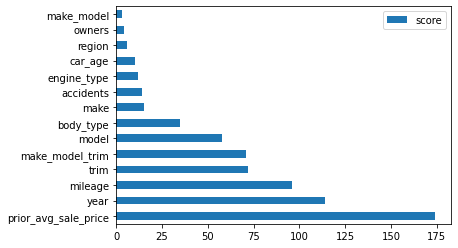

In [93]:
# Feature importance
feature_important = xgb.get_booster().get_score(importance_type='weight')



keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh')

### **10. Conclusion**

Built a regression model to predict the car acquisition price.​

Using Xgboost with parameter tuning, an r2 square of 0.85 was obtained.​

The predicted net profit on test data using Xgb is 2.95 million dollars whereas existing net profit on test data is 2.83 million dollars.​

​

There is still lots of scope for model performance improvement. Due to the time constraints, I stopped going further. These are some of the places of improvement:​

**Cold start problem:** I observed that there are many cars which occured less than 5 times in the data. In such cases, model is performing poorly. 
For example, car mercedes-benz cl 63 cl 63 amg appeared only once in the training data. So model wasn't sure how to predict the acquisition price in this instance. This is typically called cold start problem and we would typically take special care to predict prices of the first time occuring cars. Using data augmentation techniques and external data sources can further improve acquisition price prediction.​

Concentrating on places where cars are sold for a loss may yield better results. In training data, For all the cars which are sold at a loss, we can experiment with acquisition price logics and obtain better results.

Example: In trainng data, for cars sold at a loss, set acquisition price = selling price + Average profit for that type of car(make+model+trim). 